# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Import libraries

In [2]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from PIL import Image
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten


%matplotlib inline
np.random.seed(314151)

## Step 0: Load The Data

In [3]:
DATA_DIR = "./traffic-signs-data"
training_file = os.path.join(DATA_DIR, "train.p")
validation_file= os.path.join(DATA_DIR, "valid.p")
testing_file = os.path.join(DATA_DIR, "test.p")

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(4410, 32, 32, 3) (4410,)
(12630, 32, 32, 3) (12630,)


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:3]
n_classes = len(np.unique(y_train))


print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s).

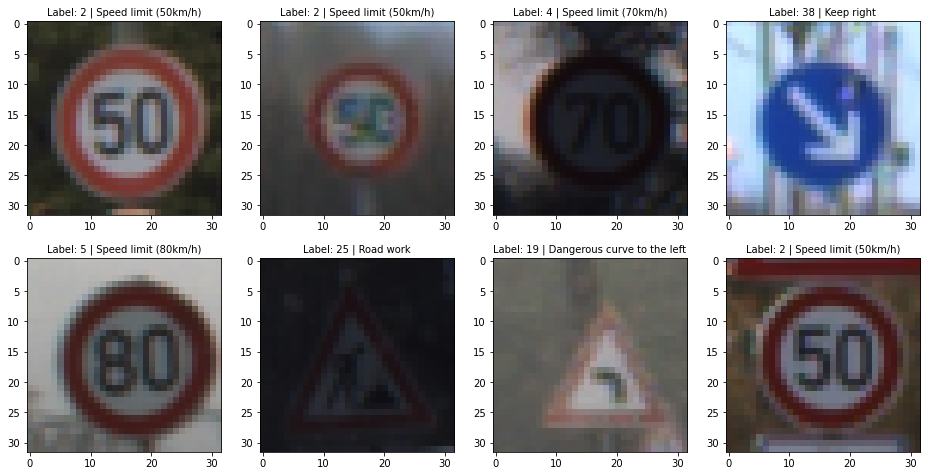

In [5]:
# Visualize traffic signs
n_cols = 4
n_rows = 2

sign_names = pd.read_csv("signnames.csv")


def show_random_images():
    random_imgs = np.random.choice(a=X_train.shape[0], size=n_cols * n_rows, replace=False)
    f, axs = plt.subplots(n_rows, n_cols, figsize=(16, 8))
    for i in range(n_rows * n_cols):
        label = y_train[random_imgs[i]]
        sign_name = sign_names[sign_names["ClassId"] == label].SignName.values[0]
        axs[i // n_cols, i % n_cols].imshow(X_train[random_imgs[i]].squeeze())
        axs[i // n_cols, i % n_cols].set_title('Label: ' + str(label) + " | " + sign_name, fontsize=10)
        
        
show_random_images()

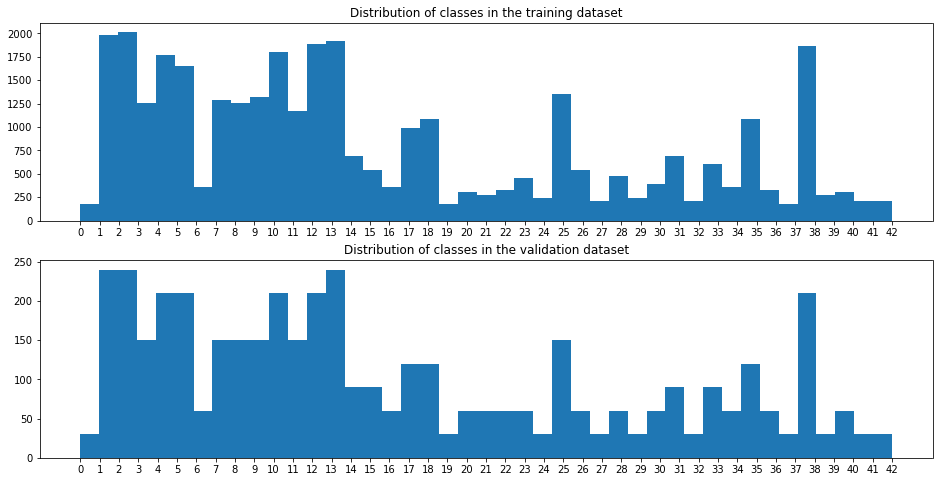

In [6]:
def show_distribution_of_signs():
    f, axs = plt.subplots(2, 1, figsize=(16, 8))
    axs[0].hist(y_train, bins=n_classes)
    axs[0].set_xticks(range(n_classes))
    axs[0].set_title("Distribution of classes in the training dataset")

    axs[1].hist(y_valid, bins=n_classes)
    axs[1].set_xticks(range(n_classes))
    axs[1].set_title("Distribution of classes in the validation dataset")
    plt.show()
    
    
show_distribution_of_signs()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point.

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

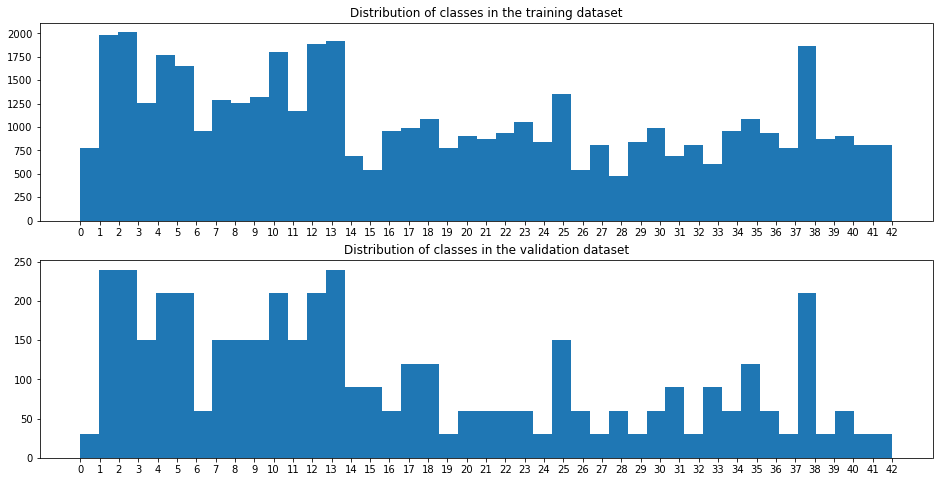

In [7]:
# Generate synthetic data for the least frequent labels
labels, counts = np.unique(y_train, return_counts=True)
labels_to_synthetize = counts.argsort()[:20]

n_synth = 600
X_synth = np.ndarray((0, 32, 32, 3), dtype=np.int32)
y_synth = np.ndarray([0], dtype=np.uint8)

for label in labels_to_synthetize:
    label_base = random.choice(X_train[y_train == label])
    noise = np.random.uniform(low=-2, high=2, size=(n_synth, image_shape[0], image_shape[1], 3))
    X_synth = np.append(X_synth, (label_base + noise).astype(np.int32), axis=0)
    y_synth = np.append(y_synth, [label] * n_synth)


assert len(X_synth) == len(y_synth)
X_train = np.concatenate((X_train, X_synth))
y_train = np.concatenate((y_train, y_synth))
show_distribution_of_signs()

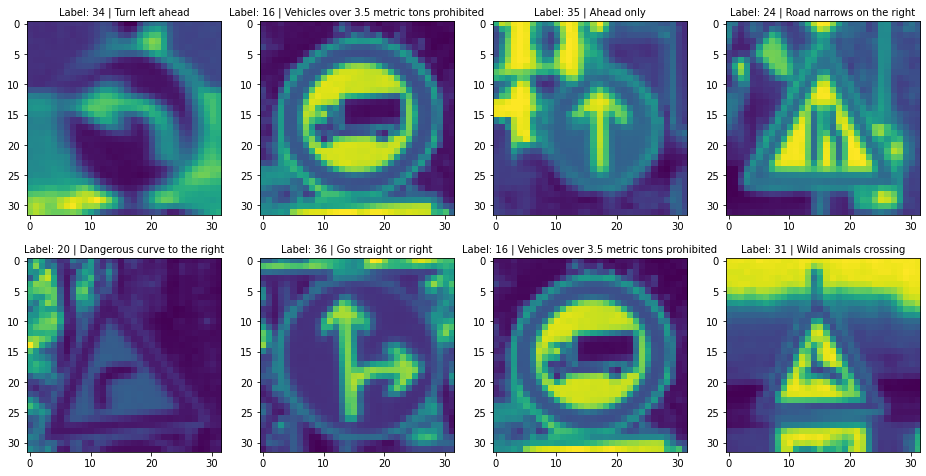

In [8]:
# Replace the unsigned type of the original images
X_train = X_train.astype(np.int32)
X_valid = X_valid.astype(np.int32)

X_train = np.sum(X_train / 3, axis=3, keepdims=True)
X_valid = np.sum(X_valid / 3, axis=3, keepdims=True)

show_random_images()

In [9]:
def standardize_image(images):
    return (images - np.mean(images)) / np.std(images)


X_train = standardize_image(X_train)
X_valid = standardize_image(X_valid)

### Model Architecture

In [10]:
EPOCHS = 15
BATCH_SIZE = 128

In [11]:
def LeNet(x, keep_prob):    
    # Global variables to visualize the layers
    global conv_1, conv_2, fc_1, fc_2
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    w_conv_1 = tf.Variable(tf.truncated_normal(shape=[5, 5, 1, 6], mean=mu, stddev=sigma))
    b_conv_1 = tf.Variable(tf.zeros([6]))
    conv_1 = tf.nn.conv2d(x, filter=w_conv_1, strides=[1, 1, 1, 1], padding="VALID")
    conv_1 = tf.nn.bias_add(conv_1, b_conv_1)

    # Activation.
    conv_1 = tf.nn.relu(conv_1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    pooling_1 = tf.nn.max_pool(conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

    # Layer 2: Convolutional. Input = 14x14x6. Output = 10x10x16.
    w_conv_2 = tf.Variable(tf.truncated_normal(shape=[5, 5, 6, 16], mean=mu, stddev=sigma))
    b_conv_2 = tf.Variable(tf.zeros([16]))
    conv_2 = tf.nn.conv2d(pooling_1, filter=w_conv_2, strides=[1, 1, 1, 1], padding="VALID")
    conv_2 = tf.nn.bias_add(conv_2, b_conv_2)
    
    # Activation.
    conv_2 = tf.nn.relu(conv_2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    pooling_2 = tf.nn.max_pool(conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

    # Flatten. Input = 5x5x16. Output = 400.
    flattened = flatten(pooling_2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    w_fc_1 = tf.Variable(tf.truncated_normal(shape=[400, 120], mean=mu, stddev=sigma))
    b_fc_1 = tf.Variable(tf.truncated_normal(shape=[120], mean=mu, stddev=sigma))
    fc_1 = tf.add(tf.matmul(flattened, w_fc_1), b_fc_1)
    
    # Activation.
    fc_1 = tf.nn.relu(fc_1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    w_fc_2 = tf.Variable(tf.truncated_normal(shape=[120, 84], mean=mu, stddev=sigma))
    b_fc_2 = tf.Variable(tf.truncated_normal(shape=[84], mean=mu, stddev=sigma))
    fc_2 = tf.add(tf.matmul(fc_1, w_fc_2), b_fc_2)
    
    # Activation.
    fc_2 = tf.nn.relu(fc_2)
    
    # Dropout
    fc_2 = tf.nn.dropout(fc_2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes (43).
    w_logits = tf.Variable(tf.truncated_normal(shape=[84, n_classes], mean=mu, stddev=sigma))
    b_logits = tf.Variable(tf.truncated_normal(shape=[n_classes], mean=mu, stddev=sigma))
    logits = tf.add(tf.matmul(fc_2, w_logits), b_logits)
    
    return logits

### Train, Validate and Test the Model

In [12]:
# Features and labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

keep_prob = tf.placeholder(tf.float32)

In [13]:
# Training pipeline
rate = 0.001

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [14]:
#  Model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [15]:
#  Train model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        print("EPOCH {} ...".format(i+1))
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})            
            
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.887
Validation Accuracy = 0.774

EPOCH 2 ...
Training Accuracy = 0.956
Validation Accuracy = 0.856

EPOCH 3 ...
Training Accuracy = 0.977
Validation Accuracy = 0.899

EPOCH 4 ...
Training Accuracy = 0.979
Validation Accuracy = 0.888

EPOCH 5 ...
Training Accuracy = 0.987
Validation Accuracy = 0.906

EPOCH 6 ...
Training Accuracy = 0.991
Validation Accuracy = 0.909

EPOCH 7 ...
Training Accuracy = 0.992
Validation Accuracy = 0.914

EPOCH 8 ...
Training Accuracy = 0.995
Validation Accuracy = 0.925

EPOCH 9 ...
Training Accuracy = 0.991
Validation Accuracy = 0.914

EPOCH 10 ...
Training Accuracy = 0.996
Validation Accuracy = 0.931

EPOCH 11 ...
Training Accuracy = 0.996
Validation Accuracy = 0.938

EPOCH 12 ...
Training Accuracy = 0.997
Validation Accuracy = 0.928

EPOCH 13 ...
Training Accuracy = 0.996
Validation Accuracy = 0.928

EPOCH 14 ...
Training Accuracy = 0.997
Validation Accuracy = 0.935

EPOCH 15 ...
Training Accuracy = 0.998
Valid

In [27]:
### Calculate the accuracy for the test set. 
X_test = X_test.astype(np.int32)
X_test_gray = np.sum(X_test / 3, axis=3, keepdims=True)
X_test_gray = standardize_image(X_test_gray)


with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    
    accuracy = evaluate(X_test_gray, y_test)
    print("Test Accuracy = {:.0f}%".format(accuracy * 100))

INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 92%


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

### Load and Output the Images

In [16]:
def display_test_images(images_test, n_cols):
    n_rows = 1
    n_cols = n_cols
    f, axs = plt.subplots(n_rows, n_cols, figsize=(24, 8))
    for i in range(len(images_test)):
        label = labels_test[i]
        sign_name = sign_names[sign_names["ClassId"] == label].SignName.values[0]
        axs[i % n_cols].imshow(images_test[i].squeeze())
        axs[i % n_cols].set_title('Label: ' + str(label) + " | " + sign_name, fontsize=10)    
    plt.show()

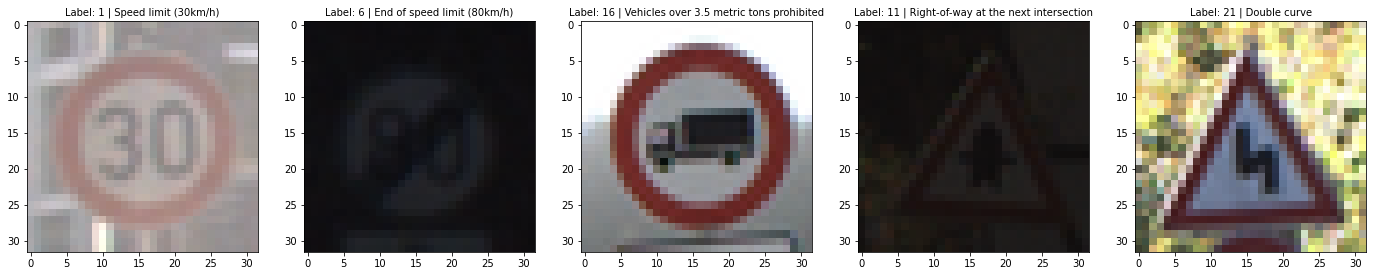

In [17]:
images = sorted(glob.glob(os.path.join(DATA_DIR, "test_simple", '*.ppm')))
labels_test = [1, 6, 16, 11, 21]

images_test = np.ndarray((0, 32, 32, 3), dtype=np.int32)

for i in range(len(labels_test)):
    # Resize the image to 32x32 pixels
    img = Image.open(images[i])
    img = img.resize((32, 32), Image.ANTIALIAS)
    img.save(fp=images[i])
    # To RGB
    img = cv2.cvtColor(cv2.imread(images[i]), cv2.COLOR_BGR2RGB)
    images_test = np.append(images_test, [img], axis=0)

display_test_images(images_test, n_cols=5)

### Predict the Sign Type for Each Image

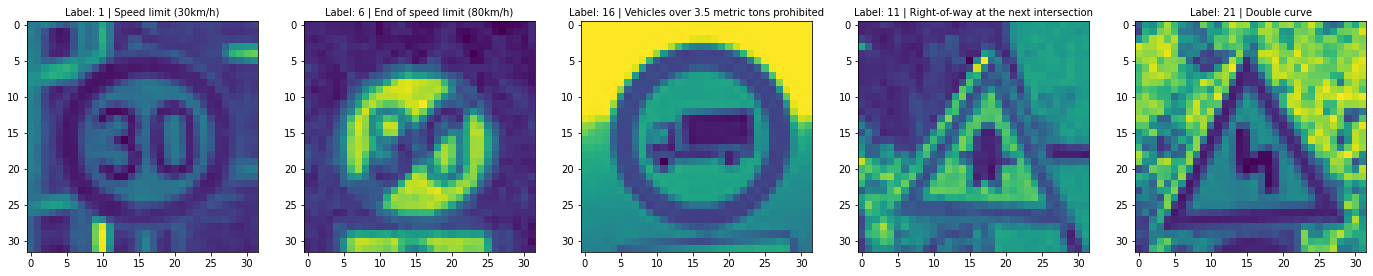

In [18]:
# Pre-process the images
images_test_gray = np.sum(images_test / 3, axis=3, keepdims=True)
display_test_images(images_test_gray, n_cols=5)
images_test_gray = standardize_image(images_test_gray)

### Analyze Performance

In [19]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    
    accuracy = evaluate(images_test_gray, labels_test)
    print("Test Accuracy = {:.0f}%".format(accuracy * 100))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./lenet
Test Accuracy = 100%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from ./lenet


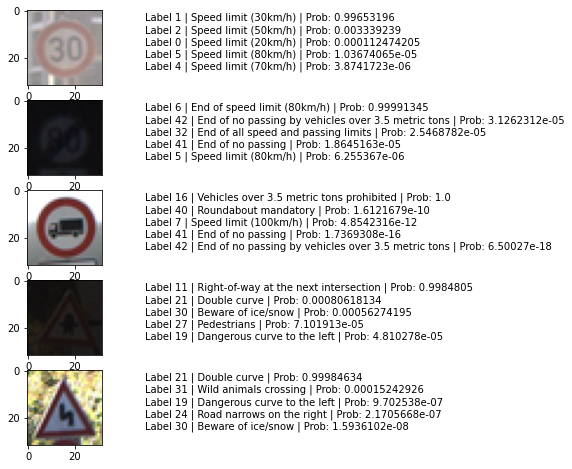

In [20]:
softmax_operation = tf.nn.softmax(logits)
top_probabilities = 5
top_k = tf.nn.top_k(softmax_operation, k=top_probabilities)

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    
    top_probs = sess.run(top_k, feed_dict={x: images_test_gray, keep_prob: 1.0})
    
    # Print the probabilities in a user-friendly way
    n_rows = len(images_test)
    fig, axs = plt.subplots(n_rows, 1, figsize=(8, 8))
    for i in range(len(top_probs[0])):
        axs[i % n_rows].imshow(images_test[i])
        labels_and_probs = ""
        for j in range(len(top_probs[1][i])):
            label = top_probs[1][i][j]
            sign_name = sign_names[sign_names["ClassId"] == label].SignName.values[0]
            prob = top_probs[0][i][j]
            labels_and_probs += "Label " + str(label) + " | " + sign_name + " | Prob: " + str(prob) + "\n"
        axs[i % n_rows].annotate(labels_and_probs, xy=(0, 0), xycoords='data', xytext=(50, 30))

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


INFO:tensorflow:Restoring parameters from ./lenet


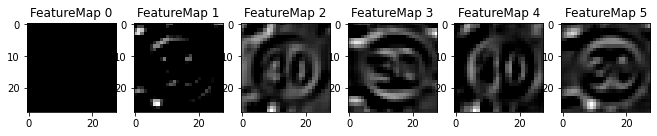

In [21]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob: 1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    img = np.expand_dims(images_test_gray[0], axis=0)
    outputFeatureMap(img, conv_1)